<a href="https://colab.research.google.com/github/twishi03/liver/blob/master/PBMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Method

In [ ]:
!pip install activeSVC==4.0.1
!pip install psutil

In [ ]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition
import pandas as pd
import pickle
import os, psutil
import resource


def text_create(path, name, msg):
    full_path = path + "/" + name + '.pickle'
    f=open(full_path,'wb')
    pickle.dump(msg,f)
    f.close()

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        return elapsed_time





# Download and Load PBMC Data

In [ ]:
import urllib.request
import shutil

with urllib.request.urlopen("https://caltech.box.com/shared/static/wqvm0d9irzb7tneb16q01fnr4dt6cvl0.csv") as response, open('./PBMCnorm_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mxnl3tu0p8ta6zehdutjg8vxpppv3t8v.csv") as response, open('./labels_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mysl5kjfq6p87ib7zygrpc61b8jyxt3g.csv") as response, open('./genes_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [ ]:
data_df = pd.read_csv('./PBMCnorm_final.csv')
label_df=pd.read_csv('./labels_final.csv',header = None)
gene_df=pd.read_csv('./genes_final.csv')
classes=[0,1,2,3,4]
keys=['Monocytes','T cells','Act. T/NK','B cells','Others']

raw_data=data_df.values
target=label_df.values.reshape((raw_data.shape[1],)).astype(np.uint8)-1
gene=gene_df.values.reshape((raw_data.shape[0],))
data=normalize(np.transpose(raw_data),axis=1, norm='l2')
del data_df,label_df,gene_df,raw_data


idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(type(data))
print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))
for i in np.unique(target):
    print('class '+keys[i]+': '+str(np.count_nonzero((target==i)*1)))

<class 'numpy.ndarray'>
(10194, 6915) (10194,) 5
(8155, 6915)
(2039, 6915)
class Monocytes: 3269
class T cells: 3517
class Act. T/NK: 1265
class B cells: 995
class Others: 1148


# min_complexity

## Define Parameters and Work Space

In [ ]:
'''
Parameters
'''
num_features = 20
num_samples=20
init_samples=100
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory results 
Successfully created the directory results/min_complexity 
Successfully created the directory results/min_complexity/test_20_20 


## Select Genes and Save Results

Elapsed time: 6.0376 seconds
feature 0 : gene [3893]  100 samples
training error=2.3970570202329857 test error=2.5267287886218734
training accuracy=0.6453709380748007 test accuracy=0.6375674350171653
Elapsed time: 3.8522 seconds
feature 1 : gene 4719  120 samples
training error=1.6712446351931332 test error=1.8067680235409513
training accuracy=0.7228694052728387 test accuracy=0.7116233447768514
Elapsed time: 4.0402 seconds
feature 2 : gene 1863  138 samples
training error=1.4657265481299817 test error=1.613536047081903
training accuracy=0.8038013488657265 test accuracy=0.784698381559588
Elapsed time: 4.2070 seconds
feature 3 : gene 4161  157 samples
training error=1.437155119558553 test error=1.5914664051005394
training accuracy=0.8134886572654813 test accuracy=0.7935262383521334
Elapsed time: 4.2577 seconds
feature 4 : gene 430  176 samples
training error=1.231023911710607 test error=1.4124570868072586
training accuracy=0.837155119558553 test accuracy=0.8219715546836684
Elapsed time: 

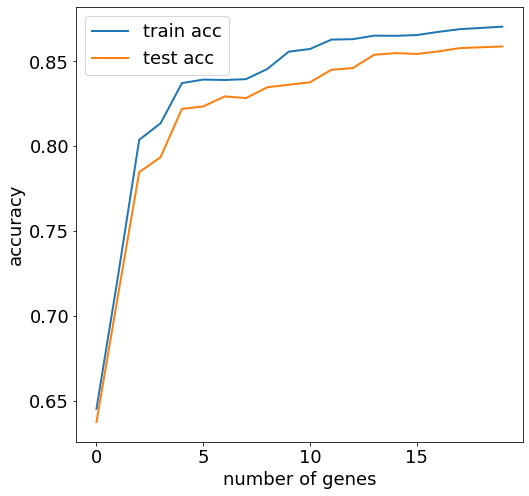

In [ ]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores, step_times= min_complexity(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples, balance=balance)
    elapsed_time=t.stop()

    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)

    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

# min_aquisition

## Define Parameters and Work Space

In [ ]:
'''
Parameters
'''
num_features = 20
num_samples=100
init_samples=200

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Successfully created the directory results/min_acquisition 
Successfully created the directory results/min_acquisition/test_50_100 


## Select Genes and Save Results

Elapsed time: 16.0672 seconds
feature 0 : gene [979]  200 samples
training error=2.352421827099939 test error=2.480137322216773
training accuracy=0.6333537706928265 test accuracy=0.6218734673859735
Elapsed time: 11.1263 seconds
feature 1 : gene 5015  246 samples
training error=2.4478234212139793 test error=2.630210887690044
training accuracy=0.6789699570815451 test accuracy=0.6596370769985287
Elapsed time: 11.3695 seconds
feature 2 : gene 452  257 samples
training error=1.703862660944206 test error=1.7577243746934772
training accuracy=0.7301042305334151 test accuracy=0.7268268759195684
Elapsed time: 12.4868 seconds
feature 3 : gene 2230  277 samples
training error=1.6176578786020845 test error=1.7189798921039725
training accuracy=0.7649294911097486 test accuracy=0.7572339382050024
Elapsed time: 13.5722 seconds
feature 4 : gene 5475  288 samples
training error=1.5469037400367873 test error=1.6012751348700343
training accuracy=0.8085836909871245 test accuracy=0.8106915154487494
Elapsed t

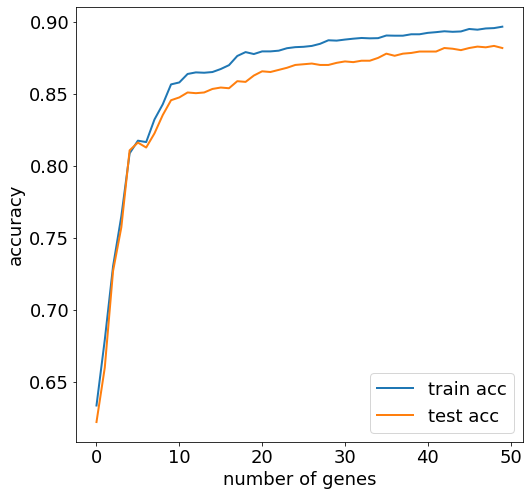

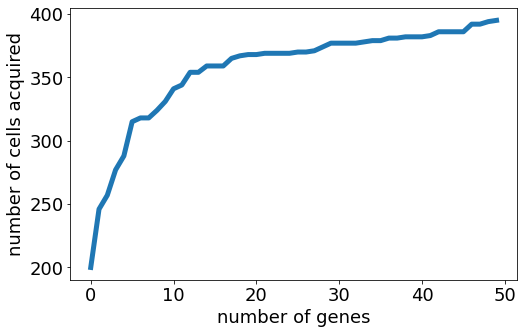

In [ ]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores,step_times= min_acquisition(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples, init_samples=init_samples)
    elapsed_time=t.stop()

    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)

    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# T-SNE of Results

## T-SNE of Original Dataset

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


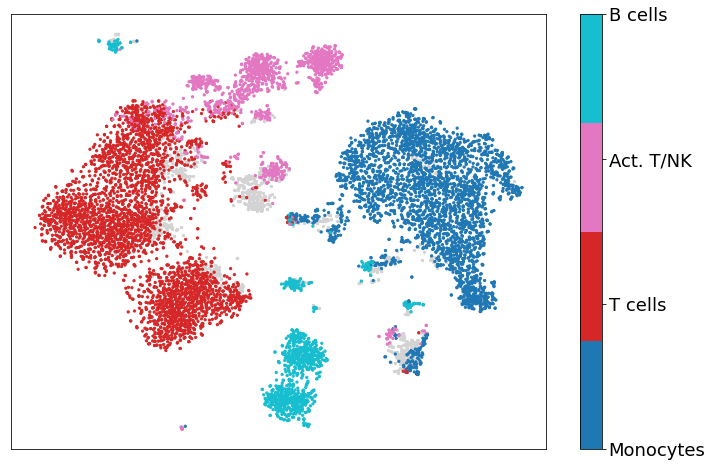

In [ ]:
plt.figure(figsize=(12,8))

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)

Y=TSNE(n_components=2).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s=5)
plt.scatter(Y[cells,0],Y[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")

f=open(path+'/tsne.pickle','wb')
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


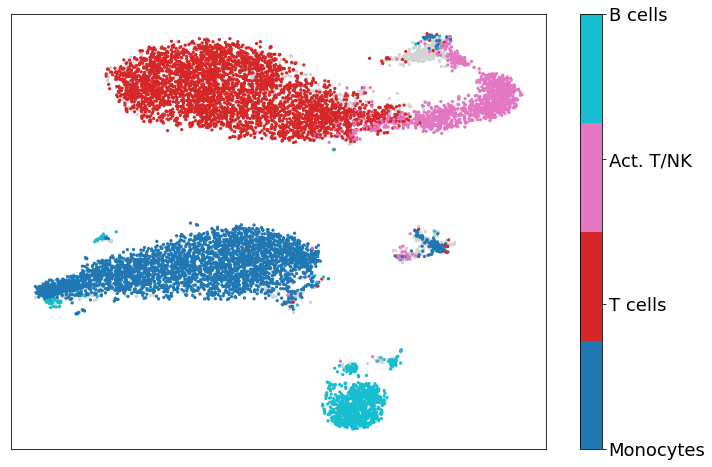

In [ ]:
plt.figure(figsize=(12,8))
data_selected=data[:,feature_selected]

pca=PCA(n_components=7,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2,perplexity=200,early_exaggeration=1).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s=5)
plt.scatter(Y_selected[cells,0],Y_selected[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wPCA.pdf',bbox_inches="tight")

f=open(path+'/tsne_selected_wPCA.pickle','wb')
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

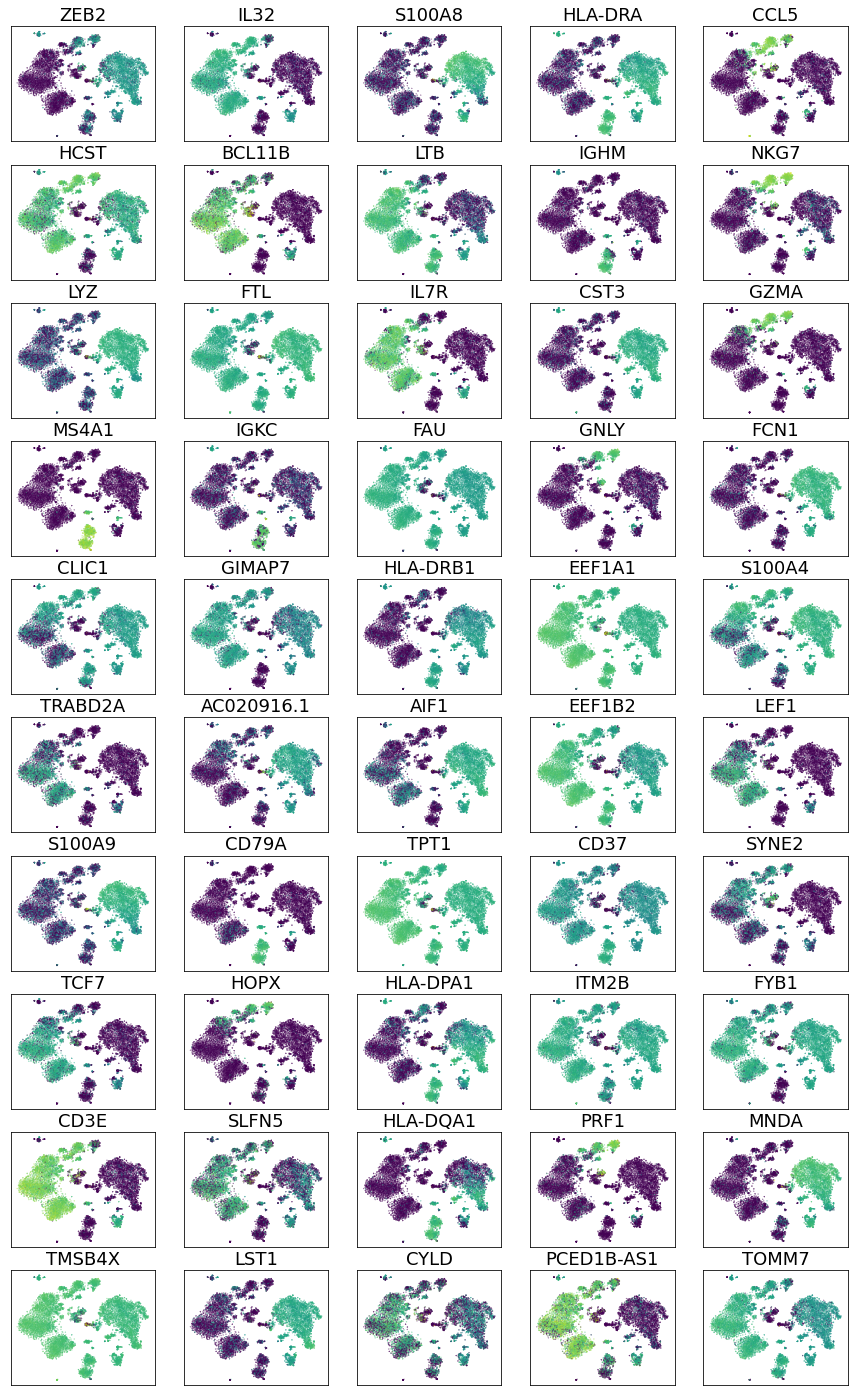

In [ ]:
alpha = 100
data_show = np.log1p(data*alpha)

size=len(feature_selected)
plt.figure(figsize=(15,2.5*int(size/5)))
gs = gridspec.GridSpec(int(size/5), 5, width_ratios=[7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data_show[:,f],s=0.05)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")